In [1]:
import pandas as pd
import os
from scipy.interpolate import PchipInterpolator
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
#dataframe datos de compositores 

datos_composers = {}
carpeta = r'Sequences\labels'
archivos_en_carpeta = os.listdir(carpeta)
print(archivos_en_carpeta)
index0 = 0
indice = 0

for archivo in archivos_en_carpeta:
    ruta_completa = os.path.join(carpeta, archivo)
    serie = pd.read_csv(ruta_completa, header = None)
    composer = archivo.split('-')[1].capitalize() # nombre compositor
    datos_composers[composer] = {} #genero bibio para composer
    datos_composers[composer]['Birth_year'] = archivo.split('-')[0] #año de nacimiento
    index1 = serie.iloc[0, 0].split('\t')[0] #el # del primer serie del composer
    index2 = int(serie.iloc[len(serie)-3, 0].split('\t')[0]) - index0 # # Piezas
    index0 = index2 + index0 # numero total de piezas anteriores
    datos_composers[composer]['# Piezas'] = index2 # Piezas
    datos_composers[composer]['Indice'] = indice
    indice += 1

datos_composers_df = pd.DataFrame(datos_composers)
print('Total Pieces = ',datos_composers_df.sum(axis=1)[1])
print(datos_composers_df)    

['1397-dufay-Labels.txt', '1500-morales-Labels.txt', '1521-desprez-Labels.txt', '1525-palestrina-Labels.txt', '1532-lasso-Labels.txt', '1538-byrd-Labels.txt', '1548-victoria-Labels.txt', '1557-gabrielis-Labels.txt', '1563-dowland-Labels.txt', '1566-gesualdo-Labels.txt', '1567-monteverdi-Labels.txt', '1583-frescobaldi-Labels.txt', '1587-scheidt-Labels.txt', '1616-froberger-Labels.txt', '1629-anglebert-Labels.txt', '1632-lully-Labels.txt', '1637-buxtehude-Labels.txt', '1653-pachelbel-Labels.txt', '1668-couperin-Labels.txt', '1671-albinoni-Labels.txt', '1678-vivaldi-Labels.txt', '1681-telemann-Labels.txt', '1682-dandrieu-Labels.txt', '1683-rameau-Labels.txt', '1685-handel-Labels.txt', '1685-scarlatti-Labels.txt', '1688-zipoli-Labels.txt', '1721-bach-js-Labels.txt', '1732-haydn-Labels.txt', '1736-albrechtsberger-Labels.txt', '1752-clementi-Labels.txt', '1756-mozart-Labels.txt', '1770-beethoven-Labels.txt', '1771-cramer-Labels.txt', '1782-paganini-Labels.txt', '1797-schubert-Labels.txt', '1

C:\Users\PC BULLOCK\AppData\Local\Temp\ipykernel_10724\1761750877.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Total Pieces = ',datos_composers_df.sum(axis=1)[1])


In [3]:
composers = {}
M = 0
carpeta = r'Sequences\Series'
archivos_en_carpeta = os.listdir(carpeta)

for archivo in archivos_en_carpeta:
    ruta_completa = os.path.join(carpeta, archivo)
    serie = pd.read_csv(ruta_completa)
    # escoge una serie
    composer = archivo.split('-')[1].capitalize() # nombre compositor
    composers[composer] = {}

    for pieza in range( datos_composers[composer]['# Piezas'] ):
        N = serie.iloc[0, 0].split('\t')[1] # # de elementos por pieza
        M = int(N) + M
        index_n1 = 0 
        index_n2 = int(N)+2 
        serie_n = serie[index_n1 + 2:index_n2].reset_index(drop=True) # resetear index
        serie = serie[index_n2 +1:] # recortar serie Original
        serie_n.index += 1 # que index empiece desde 1
        num_serie_T = serie.columns[0]  # numero de serie de todo el dataset
        num_serie = pieza + 1
        composers[composer]['Serie_'+str(num_serie)] = serie_n.squeeze().to_numpy().astype(float) # agregamos pieza al dicc composer con key como # serie
print('Número total de elementos de todo el dataset: ', M)

Número total de elementos de todo el dataset:  8250485


In [4]:
def midi_to_hz(midi_notes):
    """
    Convierte una secuencia de notas en formato MIDI a frecuencias en Hz.
    
    Args:
    midi_notes (np.array): Un array de notas MIDI.
    
    Returns:
    np.array: Un array de frecuencias correspondientes en Hz.
    """
    # Fórmula para convertir número MIDI a Hz
    freqs = 440.0 * 2 ** ((midi_notes - 69) / 12.0)
    return freqs
import copy
# composers_interp = copy.deepcopy(composers)
composers_Hz = copy.deepcopy(composers)

for composer in composers_Hz.keys():
    for pieza in composers_Hz[composer].keys():
        subject = composers[composer][pieza]
        composers_Hz[composer][pieza] = midi_to_hz(subject)

In [5]:
def interpolador(subject, method, size):
    # data = np.array([int(line.strip()) for line in subject.to_numpy()])  # Si lo obtienes de un DataFrame
    data = subject
    x = np.arange(len(data))
    
    # Crear 'size' puntos equidistantes
    x_new = np.linspace(0, len(data) - 1, size*(len(data)-1) + len(data))
    
    if method == 'lineal':
        data_interp = np.interp(x_new, x, data)
    elif method == 'herm':
        interpolator = PchipInterpolator(x, data)
        data_interp = interpolator(x_new)
    
    return x_new, data_interp

Algorithm didn't converge. No fit to plot.
Algorithm didn't converge. No breakpoints to plot
Algorithm didn't converge. No breakpoint estimates to plot


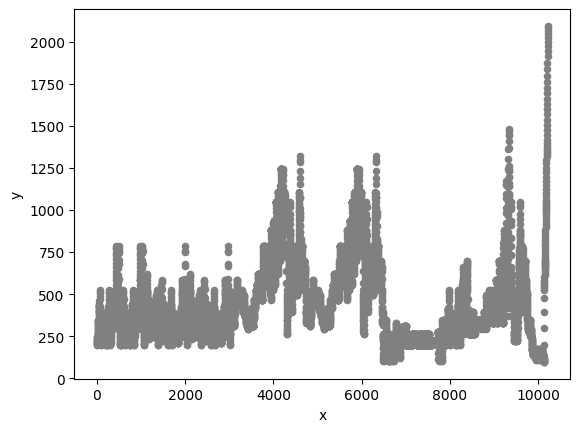

In [7]:
import piecewise_regression
import numpy as np

yy = interpolador(composers_Hz['Alkan']['Serie_114'], 'herm', 5)[1]
xx = np.arange(len(yy))

# Given some data, fit the model
pw_fit = piecewise_regression.Fit(xx, yy, start_values=[5], n_breakpoints=1)

import matplotlib.pyplot as plt

# Plot the data, fit, breakpoints and confidence intervals
pw_fit.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit.plot_fit(color="red", linewidth=4)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.close()


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def m(composer, serie):
    return interpolador(composers_Hz[composer]['Serie_'+str(serie)], 'lineal', 15)[1]
for ara in [np.loadtxt("lorenz_x_28.0.txt"),m('Debussy', 166),m('Debussy', 18),m('Debussy', 16),m('Faure',43),m('Dvorak',50),m('Dvorak', 49),m('Dvorak',48),m('Tchaikovsky', 126),m('Tchaikovsky', 120),m('Alkan', 120),m('Alkan', 114),m('Alkan', 42),m('Liszt', 22),m('Chopin',152),m('Chopin', 125), m('Schubert',7)]:

    y = np.angle(np.fft.rfft(ara[1:]))
    x = np.arange(len(y))

    # Definir las ventanas del eje x
    window_size = 7# Tamaño de la ventana en el eje x
    x_min = np.min(x)
    x_max = np.max(x)
    num_windows = int((x_max - x_min) / window_size)

    # Calcular el porcentaje de puntos dentro de la región en cada ventana
    percentages = []
    window_edges = []

    for i in range(num_windows):
        x_start = x_min + i * window_size
        x_end = x_start + window_size
        
        # Crear la máscara para la ventana actual
        mask = (x >= x_start) & (x < x_end)
        
        # Filtrar los puntos en esta ventana
        x_filtered = x[mask]
        y_filtered = y[mask]

            # Ajuste lineal
        X = x_filtered.reshape(-1, 1)  # Reorganizar x para usar en LinearRegression
        model = LinearRegression()
        model.fit(X, y_filtered)
        slope = model.coef_[0]  # Pendiente de la recta
        intercept = model.intercept_  # Intersección con el eje y

        # Definir valor de 'b'
        b = 3  # Diferencia en la intersección con el eje y

        # Crear las líneas paralelas
        y_upper_filtered = slope * x_filtered + intercept + b  # Línea por arriba
        y_lower_filtered = slope * x_filtered + intercept - b  # Línea por abajo
        
        if len(x_filtered) > 0:  # Evitar divisiones por 0
            # Contar los puntos dentro de la región
            points_inside = np.sum((y_filtered >= y_lower_filtered) & (y_filtered <= y_upper_filtered))
            total_points_in_window = len(y_filtered)
            
            # Calcular el porcentaje
            percentage_inside = (points_inside / total_points_in_window) * 100
            percentages.append(percentage_inside)
            window_edges.append((x_start, x_end))
        else:
            percentages.append(0)  # Si no hay puntos en esta ventana, porcentaje es 0
            window_edges.append((x_start, x_end))

    def find_transition_index(percentages, threshold):
        arr = np.array([np.abs(percentages[i] - percentages[i+1]) for i in range(len(percentages) - 1)])
        for i in range(len(arr)):
            if np.all(arr[i:] <= threshold):
                return i
        return -1  # En caso de que no se encuentre un punto así

    indice = find_transition_index(diferencias, threshold = 38)

    # Graficar los datos y las líneas
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, label='Datos', color='blue', s=10)
    plt.axvline(x= indice*window_size, color='red', linestyle='--', alpha=0.5)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title('Región acotada en diferentes ventanas')
    plt.grid(True)
    plt.show()


NameError: name 'diferencias' is not defined

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def arm_detector(data, num_ventanas, b):
    n = len(data)
    x = np.arange(n)
    
    # Calcular el tamaño de cada ventana
    window_size = n // num_ventanas

    # Lista para almacenar los porcentajes de puntos dentro de las regiones
    porcentajes = []

    # Ajustar y graficar el ajuste lineal por cada ventana con las líneas paralelas
    for i in range(0, n, window_size):
        end = i + window_size
        if end > n:
            end = n
        
        x_window = x[i:end].reshape(-1, 1)
        y_window = data[i:end]
        
        # Crear y ajustar el modelo de regresión lineal
        modelo = LinearRegression()
        modelo.fit(x_window, y_window)
        
        # Obtener la pendiente y la intersección de la recta ajustada
        pendiente = modelo.coef_[0]
        interseccion = modelo.intercept_
        
        # Predecir valores ajustados
        y_pred = modelo.predict(x_window)
                
        # Calcular las rectas paralelas desplazadas por 'b'
        y_paralela_superior = pendiente * x_window + (interseccion + b)
        y_paralela_inferior = pendiente * x_window + (interseccion - b)
                
        # Calcular el porcentaje de datos dentro de la región delimitada por las líneas paralelas
        dentro_region = np.sum((y_window >= y_paralela_inferior.flatten()) & (y_window <= y_paralela_superior.flatten()))
        fuera_region = len(y_window) - dentro_region
        
        # Calcular el porcentaje de datos dentro de la región respecto a los datos fuera de la región
        porcentaje = (dentro_region * 100)/(dentro_region + fuera_region)
        porcentajes.append(porcentaje)

    def indice_mayor_90(arr):
        n = len(arr)
    
        # Revisar cada índice para encontrar el primero que cumpla la condición
        for i in range(n):
            if np.all(arr[i:] > 80) and len(arr[i:]) > 4:
                return i
        # Si no hay tal índice, regresar el último índice
        print("No hay corte")
        return n 
    
    indice = indice_mayor_90(np.array(porcentajes))*window_size
    return indice

def J_univariante(X,tau, corte):
    def distancia(p1, p2):
        return np.linalg.norm(np.array(p2)-np.array(p1))
    x1 = X[tau:]
    y1 = X[:-tau]
    ff1 = np.angle(np.fft.rfft(x1))
    ff2 = np.angle(np.fft.rfft(y1))
    if corte:
        print(len(ff1),len(ff2))
        transition_point1 = arm_detector(ff1, num_ventanas=28, b = 0.6)
        transition_point2 = arm_detector(ff2, num_ventanas=28, b = 0.6)
        if transition_point1 != transition_point2:
            transition_point1 = transition_point2 = min(transition_point1, transition_point2)        
        ff2 = ff2[:transition_point2]
        ff1 = ff1[:transition_point1]
        print(len(ff1),len(ff2))
    vectores = []
    for i in range(len(ff1)-1):
        p1 = [ff1[i], ff2[i]]
        p2 = [ff1[i+1], ff2[i+1]]
        cuadrante = [[p2[0]-p1[0], p2[1]-p1[1]], [p2[0]-p1[0], p2[1]+2*np.pi-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]],[p2[0]+2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-p1[0],p2[1]-2*np.pi-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]]]
        distancia1 = [distancia(p1,c) for c in cuadrante]
        p2 = cuadrante[np.argmin(distancia1)]
        vectores.append([p2[0]-p1[0],p2[1]-p1[1]])
    angulos = []
    for i in range(len(vectores)-1):
        v1=vectores[i]
        v2=vectores[i+1]
        v1_norm=v1/np.linalg.norm(v1)
        v2_norm=v2/np.linalg.norm(v2)
        angulo=np.arccos(np.clip(np.dot(v1_norm,v2_norm),-1.0,1.0))
        cruz=v1[0]*v2[1]-v1[1]*v2[0]
        if cruz>0:
            angulo=np.pi-angulo
        if cruz==0 and angulo==0:
            angulo=angulo
        if cruz==0 and angulo<0:
            angulo=np.pi
        if cruz<0:
            angulo=angulo+np.pi
        angulos.append(angulo)
    e=[]
    for k in range(len(angulos)):
        e.append(np.exp(angulos[k]*1j))
    e1=np.sum(e)/len(angulos)
    J=1.-np.abs(e1.real)
    return J, angulos

def interpolador(subject, method, size):
    # data = np.array([int(line.strip()) for line in subject.to_numpy()])  # Si lo obtienes de un DataFrame
    data = subject
    x = np.arange(len(data))
    
    # Crear 'size' puntos equidistantes
    x_new = np.linspace(0, len(data) - 1, size*(len(data)-1) + len(data))
    
    if method == 'lineal':
        data_interp = np.interp(x_new, x, data)
    elif method == 'herm':
        interpolator = PchipInterpolator(x, data)
        data_interp = interpolator(x_new)
    
    return x_new, data_interp

In [9]:
import numpy as np

def lorenz_system(x0, y0, z0, sigma=10, rho=1005, beta=8/3, dt=0.001, steps=10000):
    """
    Simula el sistema de Lorenz usando el método de Runge-Kutta de cuarto orden.
    
    Args:
    x0, y0, z0 (float): Condiciones iniciales para x, y, z.
    sigma, rho, beta (float): Parámetros del sistema de Lorenz.
    dt (float): Tamaño del paso de tiempo.
    steps (int): Número de pasos de simulación.
    
    Returns:
    tuple: Arrays de x, y, y z con las trayectorias del sistema de Lorenz.
    """
    # Inicializar arrays
    x = np.empty(steps)
    y = np.empty(steps)
    z = np.empty(steps)
    
    # Condiciones iniciales
    x[0], y[0], z[0] = x0, y0, z0
    
    # Integración de Runge-Kutta de cuarto orden
    for i in range(1, steps):
        # Definir las funciones derivadas
        dx = lambda x, y: sigma * (y - x)
        dy = lambda x, y, z: x * (rho - z) - y
        dz = lambda x, y, z: x * y - beta * z

        # Calcular los k para Runge-Kutta
        kx1 = dx(x[i-1], y[i-1]) * dt
        ky1 = dy(x[i-1], y[i-1], z[i-1]) * dt
        kz1 = dz(x[i-1], y[i-1], z[i-1]) * dt
        
        kx2 = dx(x[i-1] + 0.5 * kx1, y[i-1] + 0.5 * ky1) * dt
        ky2 = dy(x[i-1] + 0.5 * kx1, y[i-1] + 0.5 * ky1, z[i-1] + 0.5 * kz1) * dt
        kz2 = dz(x[i-1] + 0.5 * kx1, y[i-1] + 0.5 * ky1, z[i-1] + 0.5 * kz1) * dt
        
        kx3 = dx(x[i-1] + 0.5 * kx2, y[i-1] + 0.5 * ky2) * dt
        ky3 = dy(x[i-1] + 0.5 * kx2, y[i-1] + 0.5 * ky2, z[i-1] + 0.5 * kz2) * dt
        kz3 = dz(x[i-1] + 0.5 * kx2, y[i-1] + 0.5 * ky2, z[i-1] + 0.5 * kz2) * dt
        
        kx4 = dx(x[i-1] + kx3, y[i-1] + ky3) * dt
        ky4 = dy(x[i-1] + kx3, y[i-1] + ky3, z[i-1] + kz3) * dt
        kz4 = dz(x[i-1] + kx3, y[i-1] + ky3, z[i-1] + kz3) * dt
        
        # Actualizar valores de x, y, z
        x[i] = x[i-1] + (kx1 + 2 * kx2 + 2 * kx3 + kx4) / 6
        y[i] = y[i-1] + (ky1 + 2 * ky2 + 2 * ky3 + ky4) / 6
        z[i] = z[i-1] + (kz1 + 2 * kz2 + 2 * kz3 + kz4) / 6
    
    return x, y, z


In [13]:
def m(composer,serie, n=50, step=1):
    """
    Calcula el running average (promedio móvil) de un array con una ventana deslizante de tamaño n y un paso dado.
    
    Parameters:
        array (list o np.ndarray): El array de entrada.
        n (int): Tamaño de la ventana deslizante.
        step (int): Cantidad de pasos que la ventana se desplaza cada vez. Por defecto es 1.
    
    Returns:
        np.ndarray: El array con los promedios móviles.
    """
    array = composers_Hz[composer]['Serie_'+str(serie)]
    if n <= 0:
        raise ValueError("El tamaño de la ventana debe ser mayor que 0.")
    if n > len(array):
        raise ValueError("El tamaño de la ventana no puede ser mayor que el tamaño del array.")
    if step <= 0:
        raise ValueError("El paso debe ser mayor que 0.")
    
    # Convertimos a un array de NumPy por conveniencia
    array = np.asarray(array)
    
    # Lista para almacenar los promedios
    result = []
    
    # Aplicamos la ventana deslizante con el paso definido
    for i in range(0, len(array) - n + 1, step):
        window = array[i:i + n]
        result.append(np.mean(window))
    
    return np.array(result)

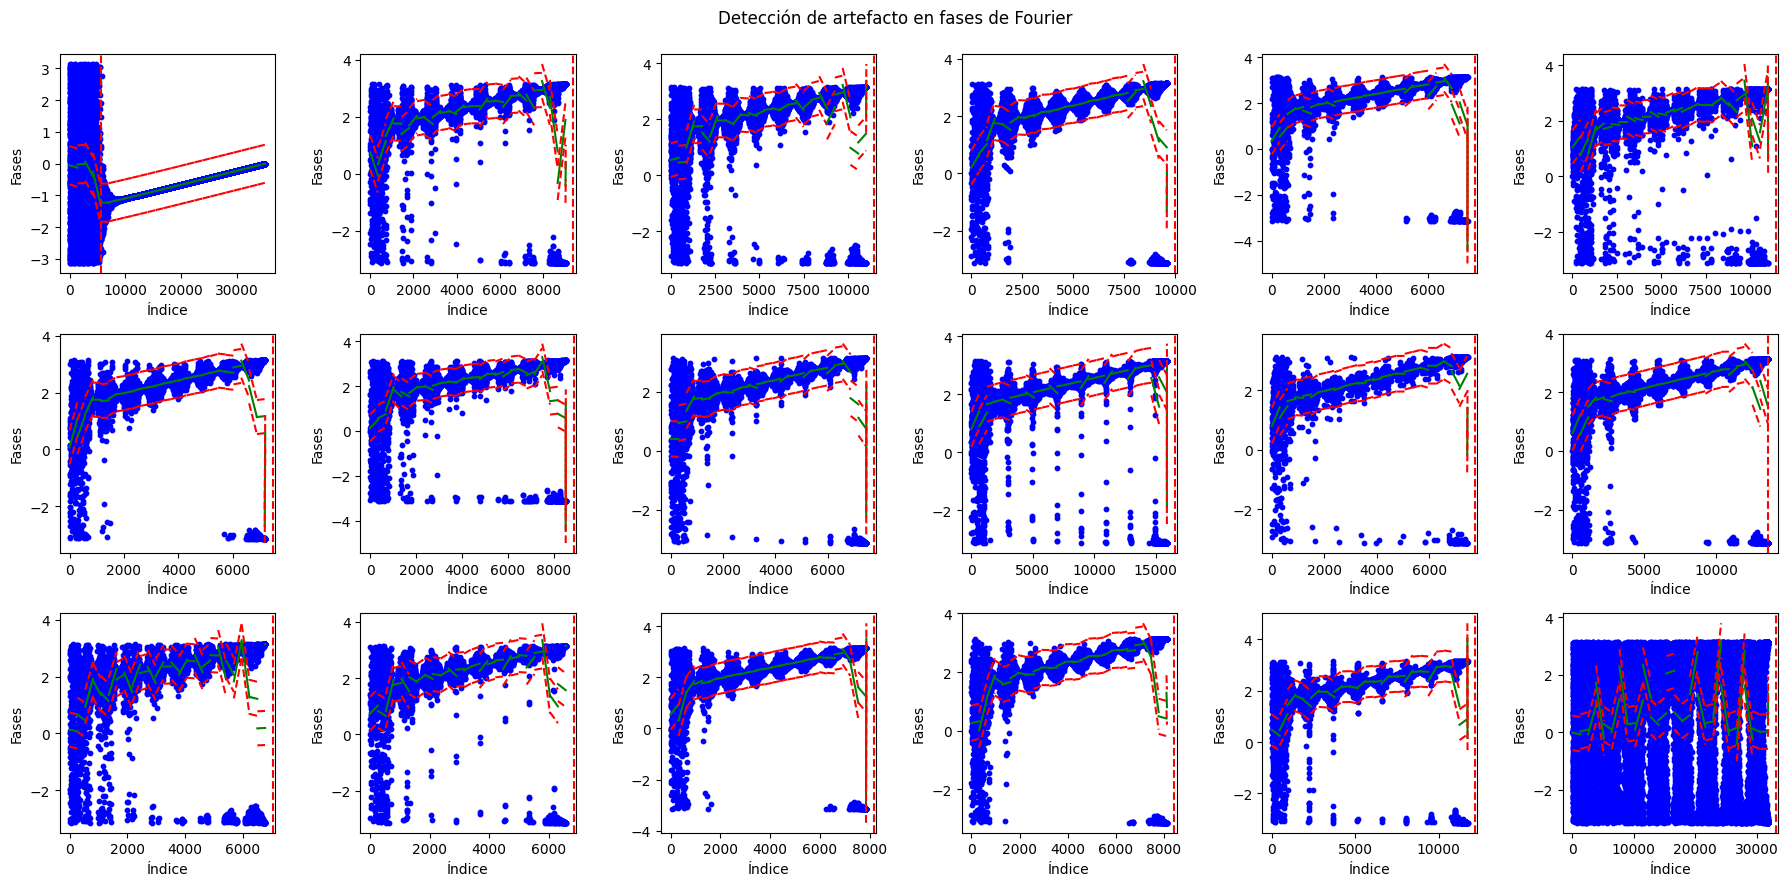

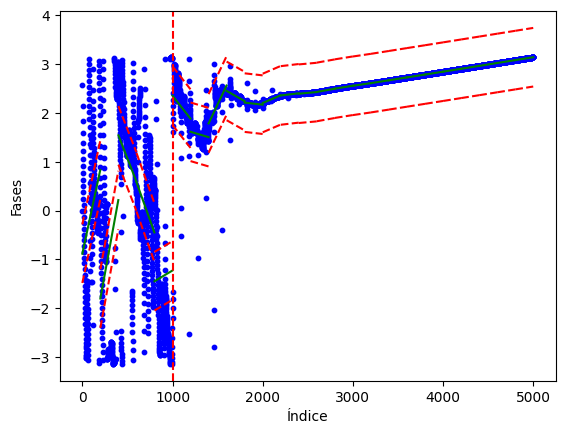

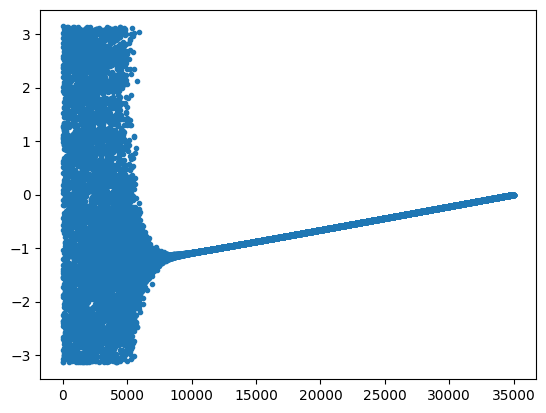

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Definir una función para ajustar una regresión lineal en un número dado de ventanas
# y agregar líneas paralelas desplazadas en 'b' unidades
def ajustar_por_num_ventanas_con_paralelas(data, num_ventanas, b,ax):
    n = len(data)
    x = np.arange(n)
    
    # Calcular el tamaño de cada ventana
    window_size = n // num_ventanas
    
    # Preparar el gráfico
    # plt.figure(figsize=(10, 6))
    ax.scatter(x, data, label="Datos originales", color='blue', s= 10)

    # Lista para almacenar los porcentajes de puntos dentro de las regiones
    porcentajes = []
    pendientes = []
    # Ajustar y graficar el ajuste lineal por cada ventana con las líneas paralelas
    for i in range(0, n, window_size):
        end = i + window_size
        if end > n:
            end = n
        
        x_window = x[i:end].reshape(-1, 1)
        y_window = data[i:end]
        
        # Crear y ajustar el modelo de regresión lineal
        modelo = LinearRegression()
        modelo.fit(x_window, y_window)
        
        # Obtener la pendiente y la intersección de la recta ajustada
        pendiente = modelo.coef_[0]
        interseccion = modelo.intercept_
        
        # Predecir valores ajustados
        y_pred = modelo.predict(x_window)
        
        # Graficar la recta ajustada para la ventana
        ax.plot(x_window, y_pred, label=f'Ajuste ventana {i//window_size + 1}', color='green')
        
        # Calcular las rectas paralelas desplazadas por 'b'
        y_paralela_superior = pendiente * x_window + (interseccion + b)
        y_paralela_inferior = pendiente * x_window + (interseccion - b)
        
        # Graficar las líneas paralelas
        ax.plot(x_window, y_paralela_superior, '--', color='red', label=f'Línea +b ventana {i//window_size + 1}')
        ax.plot(x_window, y_paralela_inferior, '--', color='red', label=f'Línea -b ventana {i//window_size + 1}')
        
        # Calcular el porcentaje de datos dentro de la región delimitada por las líneas paralelas
        dentro_region = np.sum((y_window >= y_paralela_inferior.flatten()) & (y_window <= y_paralela_superior.flatten()))
        fuera_region = len(y_window) - dentro_region
        
        # Calcular el porcentaje de datos dentro de la región respecto a los datos fuera de la región
        porcentaje = (dentro_region * 100)/(dentro_region + fuera_region)
        porcentajes.append(porcentaje)
        pendientes.append(pendiente)

    def indice_mayor_90(arr):
        n = len(arr)
    
        # Revisar cada índice para encontrar el primero que cumpla la condición
        for i in range(n): # np.all(np.array(pendientes)[i:] >= 0)
            if np.all(arr[i:] > 80) and len(arr[i:]) > 4:
                return i
        # Si no hay tal índice, regresar el último índice
        return n 
    indice = indice_mayor_90(np.array(porcentajes))*window_size
    ax.axvline(x= indice, color='red', linestyle='--', alpha=1)
    ax.set_xlabel('Índice')
    ax.set_ylabel('Fases')
    return porcentajes

# Datos de ejemplo
# data = np.loadtxt("lorenz_x_28.0.txt")

# data = np.angle(np.fft.rfft(ara[1:]))

ara = [np.loadtxt("lorenz_x_28.0.txt"),m('Debussy', 166),
            m('Debussy', 18),m('Debussy', 16),m('Faure',43),m('Dvorak',50),m('Dvorak', 49),
            m('Dvorak',48),m('Tchaikovsky', 126),m('Tchaikovsky', 120),m('Alkan', 120),
            m('Alkan', 114),m('Alkan', 42),m('Liszt', 22),m('Chopin',152),m('Chopin', 125), 
            m('Schubert',7), m('Tchaikovsky',31)]
# for ara in [np.loadtxt("lorenz_x_28.0.txt"),m('Debussy', 166),
#             m('Debussy', 18),m('Debussy', 16),m('Faure',43),m('Dvorak',50),m('Dvorak', 49),
#             m('Dvorak',48),m('Tchaikovsky', 126),m('Tchaikovsky', 120),m('Alkan', 120),
#             m('Alkan', 114),m('Alkan', 42),m('Liszt', 22),m('Chopin',152),m('Chopin', 125), 
#             m('Schubert',7)]:

#     data = np.angle(np.fft.rfft(ara[1:]))
#         # Ajustar el modelo con 3 ventanas
#     porcentajes = ajustar_por_num_ventanas_con_paralelas(data, num_ventanas=25, b = 0.6)
# print(J_univariante(m('Byrd',26), 1, True)[0])

fig, axes = plt.subplots(3, 6, figsize=(18, 9))  # 3 filas, 6 columnas, tamaño ajustado

# Iterar sobre cada subplot y añadir datos
for array, ax in zip(ara,axes.flat):  # `axes.flat` para iterar en 1D
    data = np.angle(np.fft.rfft(array[1:]))
    porcentajes = ajustar_por_num_ventanas_con_paralelas(data, num_ventanas=25, b = 0.6,ax=ax)

# Ajustar los espacios entre subplots
plt.tight_layout()
plt.suptitle(f'Detección de artefacto en fases de Fourier')
plt.subplots_adjust(top=0.93)  # Reduce el espacio reservado para las subgráficas
# Mostrar la figura
plt.show()
fig, ax = plt.subplots(1, 1)
array = m('Bach',1788)
xs, ys, zs = lorenz_system(3.083289188624795, 1.792622709328299 , 1.34, sigma=10, rho=100.5, beta=8/3, dt=0.01, steps=10000)
data = np.angle(np.fft.rfft(xs[1:]))
porcentajes = ajustar_por_num_ventanas_con_paralelas(data, num_ventanas=25, b = 0.6,ax=ax)
plt.show()
plt.plot(np.angle(np.fft.rfft(np.loadtxt("lorenz_x_28.0.txt"))), '.')


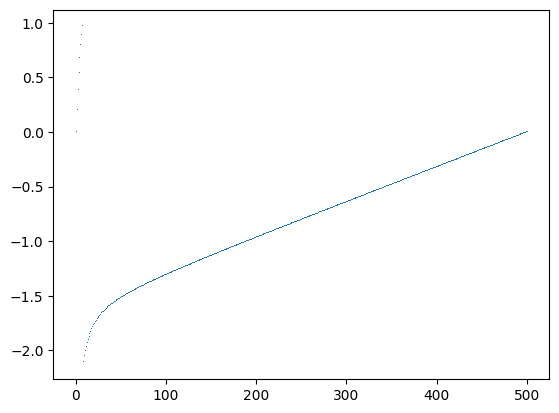

In [38]:
seno = np.sin(np.linspace(-25,25,1000) + 12)
plt.plot(np.angle(np.fft.rfft(seno)),',')

In [91]:
def brownian_bridge(t0, tT, x0, xT, n_steps=100):
    t = np.linspace(t0, tT, n_steps)
    #Generar movimiento browniano con media cero
    W = np.random.normal(0, np.sqrt(t[1] - t[0]), size=n_steps-1)
    W = np.insert(np.cumsum(W), 0, 0)  # Inserta W(0) = 0 y suma acumulativa
    # Interpolación del Brownian Bridge
    X = x0 + (t - t0) / (tT - t0) * (xT - x0) + W - (t - t0) / (tT - t0) * W[-1]
    return t, X
    
def interpolador_estocastico(s_0_discreto, n_steps):
    t_list, X_list = [], []
    for i in range(len(s_0_discreto)- 1):
        t0 = i
        tT = i+1
        x0 = s_0_discreto[i]
        xT = s_0_discreto[i+1]
        t, X = brownian_bridge(t0, tT, x0, xT, n_steps+2)
        if i == 0:
            t_list = np.concatenate((t_list, t[:]))
            X_list = np.concatenate((X_list, X[:]))
        else:
            t_list = np.concatenate((t_list, t[1:]))
            X_list = np.concatenate((X_list, X[1:]))          
    return t_list, X_list